# FashionMNIST VAE

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch
import torchvision
import torchvision.transforms as tvt
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO #, TraceGraph_ELBO
from pyro.optim import Adam, Adamax, Adadelta, SGD
from torchvision import utils
from matplotlib.pyplot import imshow
from torch.distributions import constraints
from sklearn.manifold import TSNE

from helper_functions import *
from encoder_decoder_vae import *

### Define the simulation parameters

In [ ]:
params = { 
    'K' : 10, #number of clusters
    'CHANNELS' : 1,
    'WIDTH' : 28,
    'HEIGHT':28,
    'Z_DIM':20,
    'use_cuda' : torch.cuda.is_available()
    }
print(params)

### Get the data

torch.Size([64, 1, 28, 28])


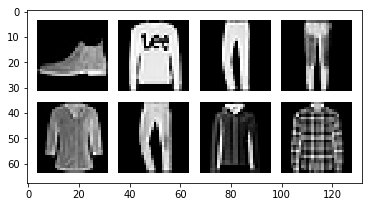

In [35]:
BATCH_SIZE = 64
kwargs = {'num_workers': 0, 'pin_memory': params["use_cuda"]}

trainset = torchvision.datasets.FashionMNIST('./FashionMNIST', train=True, download=True, transform=tvt.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
testset = torchvision.datasets.FashionMNIST('./FashionMNIST', train=False, download=True, transform=tvt.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, **kwargs)

imgs,labels = next(iter(testloader))

print(imgs.shape)
show_batch(imgs[:8],npadding=4)

### Define the VAE class 
This is the case without latent structure

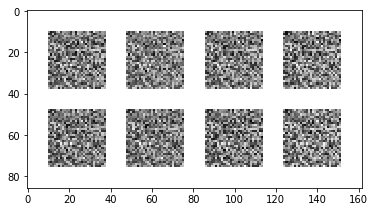

In [5]:
encoder = MLP_x_to_z(params)
decoder = MLP_z_to_x(params)
vae = VAE_no_latent_structure(params,encoder,decoder)
vae.guide()
vae.model()
imgs_rec = vae.reconstruct(imgs)
show_batch(imgs_rec[:8])

In [6]:
test_model(vae.model,vae.guide,Trace_ELBO())

#load_model(vae,"/Users/ldalessi/ENUMERATION_MNIST/ARCHIVE/","vae_v5_10")

import pyro.poutine as poutine
#
print("----MODEL---------")
trace = poutine.trace(vae.model).get_trace()
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())
#
print("----GUIDE ---------")
trace = poutine.trace(vae.guide).get_trace()
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

----MODEL---------
             Trace Shapes:            
              Param Sites:            
                     sigma       1    
decoder$$$comp_x_mu.weight 784  20    
  decoder$$$comp_x_mu.bias     784    
             Sample Sites:            
           batch_size dist       |    
                     value   8   |    
                  log_prob       |    
             z_latent dist   8   |  20
                     value   8   |  20
                  log_prob   8   |    
                  obs dist   8   | 784
                     value   8   | 784
                  log_prob   8   |    
----GUIDE ---------
              Trace Shapes:           
               Param Sites:           
    encoder$$$layer1.weight 100 784   
      encoder$$$layer1.bias     100   
 encoder$$$comp_z_mu.weight  20 100   
   encoder$$$comp_z_mu.bias      20   
encoder$$$comp_z_std.weight  20 100   
  encoder$$$comp_z_std.bias      20   
              Sample Sites:           
            batch_size di

In [7]:
pyro.clear_param_store()
pyro.set_rng_seed(0)

TEST_FREQUENCY = 5
WRITE_FREQUENCY = 20
smoke_test= False
if(smoke_test):
    pyro.enable_validation(True)
    pyro.distributions.enable_validation(True)
    NUM_EPOCHS = 21
else:
    pyro.enable_validation(False)
    pyro.distributions.enable_validation(False)
    NUM_EPOCHS = 101
    
# setup the optimizer
adam_args = {"lr": 1.0e-4}
#optimizer = Adadelta(adam_args)
optimizer = Adamax(adam_args)
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO(num_particles=1))
loss_train_history = list()
loss_test_history = list()
min_loss = 999999

In [16]:
write_dir  = '/Users/ldalessi/clustering/ARCHIVE/'
name_vae  = "vae_no_structure_v1_"
name_train_loss = "loss_train_no_structure_v1_"
name_test_loss = "loss_test_no_structure_v1_"
save_obj(params,write_dir,"params_no_structure_v1_")


# training loop
for epoch in range(47,NUM_EPOCHS):
    vae.train()    
    loss = train(svi,trainloader,use_cuda=params['use_cuda'])
    loss_train_history.append(loss)
    print("[epoch %03d] train loss: %.4f" % (epoch, loss))
       
    if(epoch < 4 % 20): 
        save_model(vae,write_dir,name_vae+str(epoch))       
        save_obj(loss_train_history,write_dir,name_train_loss+str(epoch))
        save_obj(loss_test_history,write_dir,name_test_loss+str(epoch))
    
    if(epoch % TEST_FREQUENCY ==0):
        vae.eval()
        loss_test = evaluate(svi,testloader,use_cuda=params['use_cuda'])
        loss_test_history.append(loss_test)
        if(loss_test < min_loss):
            min_loss = loss_test
            save_model(vae,write_dir,name_vae+str(epoch))       
            save_obj(loss_train_history,write_dir,name_train_loss+str(epoch))
            save_obj(loss_test_history,write_dir,name_test_loss+str(epoch))
            print("[epoch %03d]  test loss: %.4f --New Record--" % (epoch, loss_test)) 
        else:
            print("[epoch %03d]  test loss: %.4f" % (epoch, loss_test)) 

[epoch 047] train loss: -373.6338
[epoch 048] train loss: -376.4989
[epoch 049] train loss: -379.3646
[epoch 050] train loss: -382.0476
[epoch 050]  test loss: -382.0476 --New Record--
[epoch 051] train loss: -384.7284
[epoch 052] train loss: -387.3176
[epoch 053] train loss: -389.8622
[epoch 054] train loss: -392.3934
[epoch 055] train loss: -394.7735
[epoch 055]  test loss: -394.7735 --New Record--
[epoch 056] train loss: -397.2644
[epoch 057] train loss: -399.4967
[epoch 058] train loss: -401.8429
[epoch 059] train loss: -404.0720
[epoch 060] train loss: -406.2074
[epoch 060]  test loss: -406.2074 --New Record--
[epoch 061] train loss: -408.3615
[epoch 062] train loss: -410.4364
[epoch 063] train loss: -412.4535
[epoch 064] train loss: -414.5084
[epoch 065] train loss: -416.4079
[epoch 065]  test loss: -416.4079 --New Record--
[epoch 066] train loss: -418.2637
[epoch 067] train loss: -420.2110
[epoch 068] train loss: -422.0478
[epoch 069] train loss: -423.7650
[epoch 070] train loss

KeyboardInterrupt: 

# Check the results

In [ ]:
write_dir  = '/Users/ldalessi/clustering/ARCHIVE/'
load_model(vae,write_dir,"vae_no_structure_v1_125")
loss_train_history=load_obj(write_dir,"loss_train_no_structure_v1_125")
loss_test_history=load_obj(write_dir,"loss_test_no_structure_v1_125")

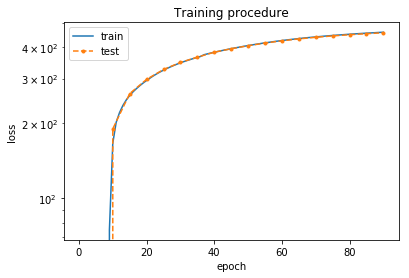

In [17]:
plt.plot(np.arange(0, len(loss_train_history)), -1*np.array(loss_train_history))
plt.plot(np.arange(0, len(loss_train_history), TEST_FREQUENCY), -1*np.array(loss_test_history), '.--')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Training procedure')
plt.legend(['train', 'test'])
plt.show()

In [18]:
# compute the embedding                                   

for i,data in enumerate(testloader):
    imgs,labs = data
    if(params['use_cuda']):
        imgs=imgs.cuda()
    z_mu_tmp, z_std_tmp = vae.encoder(imgs)
    
    if(i==0):
        x_np = imgs.view(imgs.shape[0],-1).detach().cpu().numpy()
        z_np = z_mu_tmp.detach().cpu().numpy()
        labels = labs.numpy()
    else:
        x_np = np.concatenate((x_np,imgs.view(imgs.shape[0],-1).detach().cpu().numpy()),axis=0)
        z_np = np.concatenate((z_np,z_mu_tmp.detach().cpu().numpy()),axis=0)
        labels = np.concatenate((labels, labs.numpy()),axis=0)
    
    if z_np.shape[0] >= 3000:
        break

In [11]:
x_tsne = TSNE(n_components=2).fit_transform(x_np)

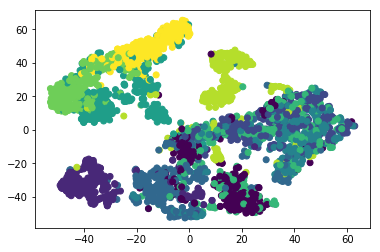

In [12]:
plt.scatter(x_tsne[:,0],x_tsne[:,1],c=labels)    
#plt.xlim(-1.0,1.0)
#plt.ylim(-1.0,1.0)

In [19]:
z_tsne = TSNE(n_components=2).fit_transform(z_np)

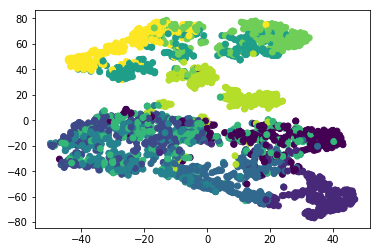

In [20]:
plt.scatter(z_tsne[:,0],z_tsne[:,1],c=labels)

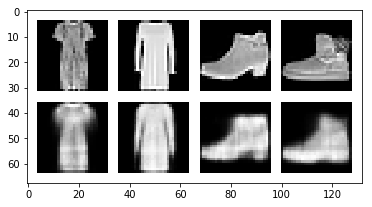

In [39]:
#imgs,labels = next(iter(testloader))
imgs,labels = next(iter(trainloader))
imgs_rec = vae.reconstruct(imgs)
show_2_batch(imgs[:4],imgs_rec[:4],npadding=4)